# Dual-Body Dissipation
Joe P. Renaud<sup>1,2,3</sup>, Wade G. Henning<sup>4,2,3</sup>, Prabal Saxena<sup>4,2,3</sup>, Marc Neveu<sup>4,2</sup>, Avi Mandell<sup>2,3</sup>, Terry Hurford<sup>2</sup>

<sub><sup>1: Universities Space Research Association</sub></sup>
<sub><sup>2: NASA Goddard Space Flight Center</sub></sup>
<sub><sup>3: Sellers Exoplanet Environments Collaboration</sub></sup>
<sub><sup>4: University of Maryland, College Park</sub></sup>

This notebook contains additional figures and calculations related to the manuscript: TBD

# Pre-Analysis Setup

In [1]:
analysis_version = '2.0'
analysis_version_save = analysis_version.replace('.', 'p')

import math
import warnings

# Third Party Package Import
import numpy as np
from scipy.constants import G
from numba import njit

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

# NaNs will pop up in some analysis. Ignore those warnings
_ = np.seterr(invalid='ignore')

In [2]:
%matplotlib notebook

In [3]:
# TidalPy Import
from TidalPy.tools.conversions import semi_a2orbital_motion, orbital_motion2semi_a, rads2days, days2rads
from TidalPy.utilities.numpyHelper.array_other import neg_array_for_log_plot, find_nearest
from TidalPy.graphics.cmaps import vik_map, tofino_map
from TidalPy.constants import radius_earth, mass_earth, au

## Define Plot Styles

In [4]:
plt.rcParams.update({'font.size': 14})

satur_perc = .8
vik_N = vik_map.N

# Colorblind safe reds and blues
red = vik_map(math.floor(vik_N * satur_perc))
blue = vik_map(math.floor(vik_N * (1 - satur_perc)))

## Define object parameters

In [14]:
objects = dict()

pluto = {
    'name': 'Pluto',
    'mass': 1.309e22,
    'radius': 1.1899e6,
    'semi_a': 1.9599e7,  # Charon's Semi-Major Axis
    'spin_rate': 2. * np.pi / (86400. * 6.387229),
    'tidal_scale': 1.,
    'host': None
}
objects['Pluto'] = pluto

charon = {
    'name': 'Charon',
    'mass': 1.62e21,
    'radius': 6.06e5,
    'semi_a': 1.9599e7,
    'spin_rate': 2. * np.pi / (86400. * 6.387229),
    'tidal_scale': 1.,
    'host': pluto
}
objects['Charon'] = charon
pluto['host'] = charon

TRAPPIST1 = {
    'name': 'TRAPPIST-1',
    'mass': 2.0e29,
    'radius': 8.3e7,
    'k2': 0.33,
    'tidal_scale': 1.,
    'host': None
}
objects['TRAPPIST-1'] = TRAPPIST1

TRAPPIST1_e = {
    'name': 'TRAPPIST1-e',
    'mass': 0.62 * mass_earth,      # Nearly 94% error in this measurement
    'radius': 0.918 * radius_earth, # About a 5% error in this measurement
    'semi_a': 0.02817 * au,         # 3% error
    'tidal_scale': 1.,
    'host': TRAPPIST1
}
objects['TRAPPIST-1 e'] = TRAPPIST1_e

for object_name, object_data in objects.items():

    # Calculate basic geometry
    object_data['volume'] = (4. / 3.) * np.pi * object_data['radius']**3
    object_data['density_bulk'] = object_data['mass'] / object_data['volume']
    object_data['gravity_surface'] = G * object_data['mass'] / object_data['radius']**2
    object_data['beta'] = object_data['radius'] * object_data['gravity_surface'] * object_data['density_bulk']
    object_data['moi'] = (2. / 5.) * object_data['mass'] * object_data['radius']**2
    if 'moi_scale' in object_data:
        object_data['moi'] *= object_data['moi_scale']

    # If satellite, calculate orbital frequency
    if object_data['host'] is not None:
        host = object_data['host']
        object_data['orbital_freq'] = semi_a2orbital_motion(object_data['semi_a'], host['mass'], object_data['mass'])

## Material Properties & Complex Compliance Functions

In [6]:
from TidalPy.rheology.complexCompliance.compliance_models import andrade_array, maxwell_array, sundberg_array, off_array

rock_viscosity = 1.0e22
rock_shear = 1.0e10
ice_viscosity = 5.0e14
ice_shear = 3.3e9

rheologies = {
    'Andrade': (andrade_array, (0.3, 1.0)),
    'Maxwell': (maxwell_array, tuple()),
    'Sundberg': (sundberg_array, (0.2, 0.02, 0.3, 1.0)),
    'Off': (off_array, tuple())
}

rheologies['Sundberg-Cooper'] = rheologies['Sundberg']

## Setup Tidal Calculation Functions


In [7]:
from TidalPy.tides.mode_manipulation import build_mode_manipulators
from TidalPy.dynamics import spin_rate_derivative, semia_eccen_derivatives_array_dual
from TidalPy.tides.dissipation import calc_tidal_susceptibility

# Tidal dissipation calculator
def build_tide_func(object_dict, host_dict,
                    complex_comp_func=None, complex_comp_input=None, use_ctl_cpl=False, eccentricity_truncation_lvl=10,
                    use_obliquity=True, max_order_l=2):

    # Pull out information from the object & host dictionaries
    object_mass = object_dict['mass']
    object_radius = object_dict['radius']
    object_gravity = object_dict['gravity_surface']
    object_density = object_dict['density_bulk']
    tidal_scale = object_dict['tidal_scale']

    tidal_host_mass = host_dict['mass']

    if use_ctl_cpl:
        # CTL/CPL not supported for l != 2
        max_order_l_to_use = 2
    else:
        max_order_l_to_use = max_order_l

        if complex_comp_input is None or complex_comp_func is None:
            raise Exception

        if complex_comp_input is None:
            complex_comp_input = tuple()


    calculate_terms, collapse_modes = \
        build_mode_manipulators(max_order_l_to_use, eccentricity_truncation_lvl, use_obliquity)

    def calculate_tides_func(orbital_freq, spin_freq, eccentricity, obliquity, semi_major_axis=None,
                             shear_modulus=None, viscosity=None, fixed_q=None, k2=None, dt_scale=None):

        if shear_modulus is None:
            shear_modulus = 1.
        compliance = shear_modulus**(-1)

        if semi_major_axis is None:
            semi_major_axis = orbital_motion2semi_a(orbital_freq, tidal_host_mass, object_mass)

        # Calculate Tidal Susceptibility
        tidal_susceptibility = calc_tidal_susceptibility(tidal_host_mass, object_radius, semi_major_axis)

        # Calculate Tidal Terms
        unique_frequencies, results_by_frequency = \
            calculate_terms(orbital_freq, spin_freq, eccentricity, obliquity, semi_major_axis, object_radius)

        # For each unique frequency, calculate complex compliance
        if not use_ctl_cpl:
            compliance_by_freq = tuple([complex_comp_func(freq, compliance, viscosity, *complex_comp_input)
                                  for freq_sig, freq in unique_frequencies.items()])

        else:
            if k2 is None or fixed_q is None:
                raise Exception

            if dt_scale is None:
                # Use CPL method
                compliance_by_freq = tuple([k2 * (1.0 + 1.0j * (1. / fixed_q))
                                      for freq_sig, freq in unique_frequencies.items()])
            else:
                # Use CTL method
                compliance_by_freq = tuple([k2 * (1.0 + 1.0j * (dt_scale * freq))
                                      for freq_sig, freq in unique_frequencies.items()])

        # Collapse Modes
        tidal_heating, dUdM, dUdw, dUdO, love_number, negative_imk = \
            collapse_modes(object_gravity, object_radius, object_density, shear_modulus,
                           compliance_by_freq, results_by_frequency, tidal_susceptibility, tidal_host_mass, tidal_scale)

        return tidal_heating, (dUdM, dUdw, dUdO), love_number, negative_imk

    return calculate_tides_func


# Tidal derivative calculator
def build_derivative_func(object1_dict, object2_dict):

    # Pull out data from dictionaries
    obj1_mass = object1_dict['mass']
    obj1_moi = object1_dict['moi']
    obj2_mass = object2_dict['mass']
    obj2_moi = object2_dict['moi']

    @njit
    def calc_derivatives_func(semi_major_axis, orbital_freq, eccentricity, obj1_partial_derivs, obj2_partial_derivs):


        dUdM_obj1, dUdw_obj1, dUdO_obj1 = obj1_partial_derivs
        dUdM_obj2, dUdw_obj2, dUdO_obj2 = obj2_partial_derivs

        # Calculate change in spin-rate
        dspin_dt_obj1 = spin_rate_derivative(dUdO_obj1, obj1_moi, obj2_mass)
        dspin_dt_obj2 = spin_rate_derivative(dUdO_obj2, obj2_moi, obj1_mass)

        # Calculate dual dissipation derivatives
        da_dt, de_dt = semia_eccen_derivatives_array_dual(semi_major_axis, orbital_freq, eccentricity,
                                                          obj1_mass, dUdM_obj1, dUdw_obj1,
                                                          obj2_mass, dUdM_obj2, dUdw_obj2)

        # Convert results to something more readable
        # # Convert from "per sec" to "per yr"
        da_dt *= 3.154e7
        de_dt *= 3.154e7

        # # Convert semi-a to km instead of m
        da_dt = da_dt / 1000.

        # # Convert from "per sec^2" to "per yr^2"
        dspin_dt_obj1 *= 3.154e7**2
        dspin_dt_obj2 *= 3.154e7**2

        # # Convert radians to degs
        dspin_dt_obj1 *= (360. / (2. * np.pi))
        dspin_dt_obj2 *= (360. / (2. * np.pi))

        return dspin_dt_obj1, dspin_dt_obj2, da_dt, de_dt

    return calc_derivatives_func

### Default Dual-Body Targets

In [18]:
default_obj1 = pluto
default_obj2 = charon
default_obj1_rheology = rheologies['Sundberg']
default_obj2_rheology = rheologies['Sundberg']

default_obj1_tide_calc = build_tide_func(default_obj1, default_obj2, *default_obj1_rheology, use_ctl_cpl=False)
default_obj2_tide_calc = build_tide_func(default_obj2, default_obj1, *default_obj2_rheology, use_ctl_cpl=False)
default_derivative_calc = build_derivative_func(default_obj1, default_obj2)

# Main Analysis & Plotting
## Exoplanet Plots
### Truncation Level Differences

In [8]:
def truncation_level_plots(target_object, host_object, obliquity=0.,
                           host_k2=0.33, host_q=8000.,
                           target_viscosity=rock_viscosity, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                           zpoints=np.linspace(-4, 4, 61), zticks=(-4, -2, 0, 2, 4), add_save_name: str = None,
                           save_fig=True):
    
    print('This plot can take a while the first time it is run after a restart (functions are compiling).')
    # Pull out data
    constant_orbital_freq = target_object['orbital_freq']
    constant_host_spin_rate = constant_orbital_freq
    host_obliquity = 0.
    derivative_calc = build_derivative_func(host_object, target_object)
    constant_semi_major_axis = orbital_motion2semi_a(constant_orbital_freq, host_object['mass'], target_object['mass'])

    # Domains
    eccentricity_domain = np.logspace(-2, 0., 800)
    spin_scale_domain = np.linspace(0., 3., 850)
    #    Make sure to hit resonances
    spin_scale_domain_res = np.asarray([0.5, 1., 1.5, 2., 2.5, 3.])
    spin_scale_domain = np.concatenate((spin_scale_domain, spin_scale_domain_res))
    spin_scale_domain = np.sort(spin_scale_domain)
    spin_domain = spin_scale_domain * constant_orbital_freq
    eccentricity, spin_rate = np.meshgrid(eccentricity_domain, spin_domain)
    shape = eccentricity.shape
    eccentricity = eccentricity.flatten()
    spin_rate = spin_rate.flatten()

    # Make sure that all input arrays have the correct shape
    x = eccentricity_domain
    y = spin_scale_domain
    obliquity *= np.ones_like(eccentricity)
    host_obliquity *= np.ones_like(eccentricity)
    constant_orbital_freq *= np.ones_like(spin_rate)
    constant_semi_major_axis *= np.ones_like(spin_rate)
    constant_host_spin_rate *= np.ones_like(constant_orbital_freq)
    #   Find spin_sync index
    sync_index = find_nearest(spin_scale_domain, 1.)

    # Cases that are plotted (must be equal to 4, must have the format (order-l, eccentricity_trunc)
    cases = [(2, 2), (2, 6), (2, 10), (2, 20)]
    case_line_styles = ['-', '--', '-.', ':']
    case_names = ['$\\mathcal{O}(e^{' + f'{trunc_level}' + '}$)' if order_l == 2 
                  else '$l = ' + order_l + '\\mathcal{O}(e^{' + f'{trunc_level}' + '}$)'
                  for order_l, trunc_level in cases]

    # Setup plots
    #    Contour Figure
    fig_contours = plt.figure(figsize=(6.4*1.75, 4.8), constrained_layout=True)
    ratios = (.249, .249, .249, .249, .02)
    gs_contours = GridSpec(1, 5, figure=fig_contours, width_ratios=ratios)
    case_contour_axes = [fig_contours.add_subplot(gs_contours[0, i]) for i in range(4)]
    colorbar_ax = fig_contours.add_subplot(gs_contours[0, 4])

    #    Spin-sync Figure
    fig_sync, sync_axes = plt.subplots(ncols=2, figsize=(1.5 * 6.4, 4.8))
    fig_sync.subplots_adjust(wspace=0.3)
    fig_sync.suptitle('Spin Synchronous', fontsize=16)
    sync_heating_ax = sync_axes[0]
    sync_eccen_ax = sync_axes[1]

    # Labels
    for ax in [sync_heating_ax, sync_eccen_ax] + case_contour_axes:
        ax.set(xlabel='Eccentricity', xscale='log')
        
    for ax in fig_contours.get_axes():
        ax.label_outer()

    case_contour_axes[0].set(ylabel='$\\dot{\\theta} \\; / \\; n$')
    sync_heating_ax.set(ylabel='Tidal Heating [W]', yscale='log')
    sync_eccen_ax.set(ylabel='$\\dot{e}$ [yr$^{-1}$]', yscale='log')

    for case_i, (order_l, eccentricity_trunc) in enumerate(cases):

        # Need to build a new tidal calculation function based on this truncation level
        rheology = rheologies[target_rheo]
        target_tide_calc = build_tide_func(target_object, host_object, *rheology, use_ctl_cpl=False,
                                           eccentricity_truncation_lvl=eccentricity_trunc, max_order_l=order_l)

        # For this analysis we always assume the host body is dissipating like a constant fixed q.
        #     This will not affect the contours, only the orbital derivatives.
        # TODO: For the time being the fixed-Q method only allows for order-l = 2
        if order_l > 2:
            warnings.warn('Order l > 2 case encountered. Tidal Host forced to used l=2. Will not affect contour plots.')
        host_tide_calc = build_tide_func(host_object, target_object, *rheology, use_ctl_cpl=True,
                                         eccentricity_truncation_lvl=eccentricity_trunc, max_order_l=2)

        # Calculate tides
        tidal_heating_targ, partial_derivatives_targ, love_number_targ, negative_imk_targ = \
            target_tide_calc(constant_orbital_freq, spin_rate, eccentricity, obliquity,
                             semi_major_axis=constant_semi_major_axis,
                             shear_modulus=target_shear, viscosity=target_viscosity)

        tidal_heating_host, partial_derivatives_host, love_number_host, negative_imk_host = \
            host_tide_calc(constant_orbital_freq, constant_host_spin_rate, eccentricity, host_obliquity,
                           semi_major_axis=constant_semi_major_axis,
                           fixed_q=host_q, k2=host_k2, dt_scale=None)

        # Calculate Derivatives
        dspin_dt_host, dspin_dt_targ, da_dt, de_dt = \
            derivative_calc(constant_semi_major_axis, constant_orbital_freq, eccentricity,
                            partial_derivatives_host, partial_derivatives_targ)

        # Reshape
        tidal_heating_targ = tidal_heating_targ.reshape(shape)
        dspin_dt_targ = dspin_dt_targ.reshape(shape)
        de_dt = de_dt.reshape(shape)

        # Prep for log plotting
        dspin_dt_targ_pos, dspin_dt_targ_neg = neg_array_for_log_plot(dspin_dt_targ)
        de_dt_pos, de_dt_neg = neg_array_for_log_plot(de_dt)

        dspin_dt_targ_combo = np.log10(np.copy(dspin_dt_targ_pos))
        negative_index = ~np.isnan(dspin_dt_targ_neg)
        dspin_dt_targ_combo[negative_index] = -np.log10(dspin_dt_targ_neg[negative_index])

        # Plot Contours
        case_name = case_names[case_i]
        contour_ax = case_contour_axes[case_i]
        contour_ax.set(title=case_name)
        cb_data = contour_ax.contourf(x, y, dspin_dt_targ_combo, zpoints, cmap=vik_map)
        contour_ax.contour(x, y, dspin_dt_targ_combo, zpoints, cmap=vik_map)

        # Plot Spin Sync
        case_style = case_line_styles[case_i]
        #    Find sync data
        tidal_heating_sync = tidal_heating_targ[sync_index, :]
        de_dt_neg_sync = de_dt_neg[sync_index, :]
        de_dt_pos_sync = de_dt_pos[sync_index, :]
        #    Plot
        sync_heating_ax.plot(x, tidal_heating_sync, c=red, ls=case_style, label=case_name)
        sync_eccen_ax.plot(x, de_dt_neg_sync, c=blue, ls=case_style, label=case_name)
        sync_eccen_ax.plot(x, de_dt_pos_sync, c=red, ls=case_style)
        
        print(f'Case {case_i} completed.')

    # Add Colorbar
    cb = plt.colorbar(cb_data, pad=0.05, cax=colorbar_ax, ticks=zticks)
    cb.set_label('$\\ddot{\\theta}$ [log$_{10}$ deg yr$^{-1}$]')
    
    # Add Spin-Sync Legend
    custom_lines = [Line2D([0], [0], color='k', lw=2, ls=style) for style in case_line_styles]
    sync_heating_ax.legend(custom_lines, case_names, loc='upper left')

    # Add Annotations
    #    3:2 Arrows
    arrow_ax = case_contour_axes[0]
    arrow_ax.annotate(
            '', xy=(.9, .75), xytext=(.9, .49), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops={'arrowstyle': '<-', 'lw': 2})
    arrow_ax.annotate(
            '', xy=(.9, .15), xytext=(.9, .47), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops={'arrowstyle': '<-', 'lw': 2})
    arrow_ax.text(.27, .23, 'Accelerating\nSpin-Rate', fontsize=12, ha='center')
    arrow_ax.text(.27, 2.35, 'Decelerating\nSpin-Rate', fontsize=12, ha='center')
    arrow_ax.text(.07, 1.65, 'Circularization &\nResonance Fall-Off', fontsize=12, ha='center')

    #    3:2 R to L
    arrow_ax.annotate(
            '', xy=(.85, .5), xytext=(.5, .5), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops={'arrowstyle': '<-', 'lw': 2})
    arrow_ax.annotate(
            '', xy=(.4, .5), xytext=(.25, .32), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops={'arrowstyle': '<-', 'lw': 2})

    #    Add Mercury Marker
    merc_ax = case_contour_axes[2]
    merc_x = 0.205630
    merc_y = 1.5
    merc_ax.text(.055, merc_y * 1.05, 'Mercury', fontsize=12)
    merc_ax.plot([merc_x], [merc_y], 'kx')

    if save_fig:
        save_name = analysis_version_save + 'TruncationPlot_' + target_object['name'] + '_' + host_object['name']
        if add_save_name is not None:
            save_name = add_save_name + save_name

        fig_contours.savefig(save_name + '_Contours.pdf')
        fig_sync.savefig(save_name + '_SpinSync.pdf')

    plt.show()
    return fig_contours, fig_sync

This plot can take a while the first time it is run after a restart (functions are compiling).


<IPython.core.display.Javascript object>


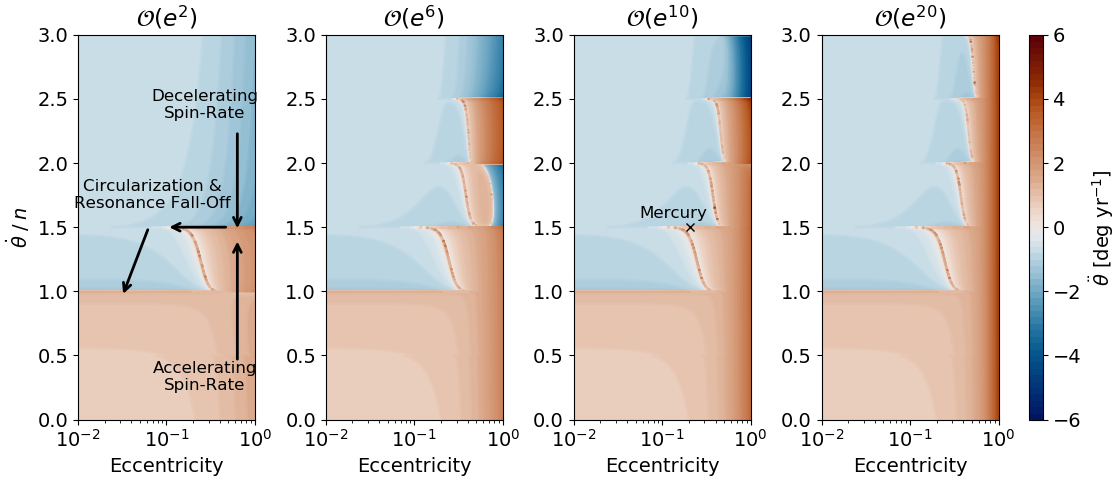

<IPython.core.display.Javascript object>


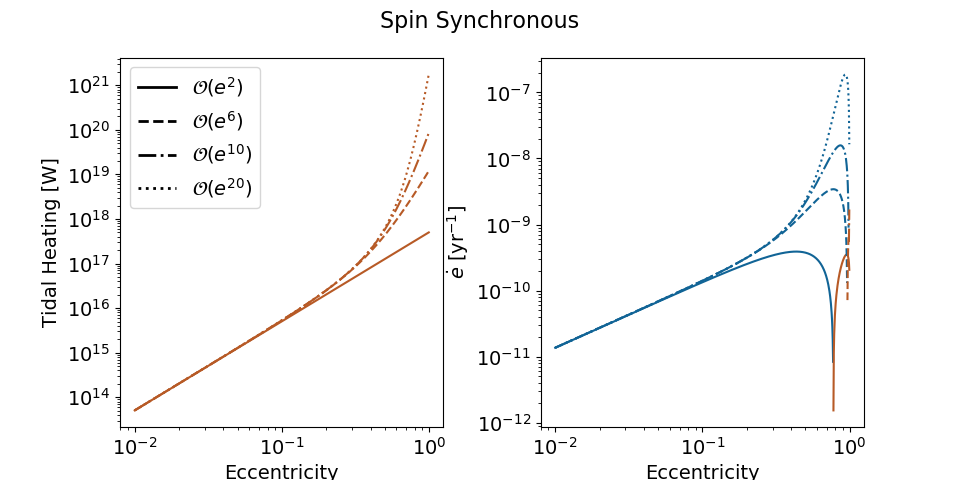

Case 0 completed.
Case 1 completed.
Case 2 completed.
Case 3 completed.


(<Figure size 1120x480 with 5 Axes>, <Figure size 960x480 with 2 Axes>)

In [23]:
truncation_level_plots(TRAPPIST1_e, TRAPPIST1, obliquity=0., host_k2=0.33, host_q=8000.,
                       target_viscosity=rock_viscosity, target_shear=rock_shear, target_rheo='Sundberg-Cooper',
                       zpoints=np.linspace(-6, 6, 61), zticks=(-6, -4, -2, 0, 2, 4, 6),
                       save_fig=True, add_save_name=None)

In [37]:
def higher_order_l_compare(object1_dict, object2_dict,
                           obj1_viscosity=5.0e14, obj1_shear=3.3e9, obj1_rheology='Sundberg-Cooper',
                           obj2_viscosity=5.0e14, obj2_shear=3.3e9, obj2_rheology='Sundberg-Cooper',
                           eccentricity_truncation=10,
                           eccentricities=(0.01, 0.6), obj1_obliquity = 0., obj2_obliquity = 0.,
                           zpoints_heating=np.linspace(0, 1, 61), zticks_heating=(0, 1),
                           zpoints_eccen=np.linspace(-1, 1, 61), zticks_eccen=(-1, 0, 1),
                           add_save_name: str = None, save_fig=True):
    
    order_ls = [2, 3, 7]
    obj1_tidal_calcs = dict()
    obj2_tidal_calcs = dict()
    
    # Pull out information
    obj1_rheology = rheologies[obj1_rheology]
    obj2_rheology = rheologies[obj2_rheology]
    derivative_calc = build_derivative_func(object1_dict, object2_dict)
    
    # Setup Tidal Calcs
    print('Building Tidal Calculation Functions - This can take a while')
    for max_order_l in order_ls:
        
        obj1_tidal_calc = \
            build_tide_func(object1_dict, object2_dict, *obj1_rheology, use_ctl_cpl=False,
                            eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=max_order_l)
        
        obj2_tidal_calc = \
            build_tide_func(object2_dict, object1_dict, *obj2_rheology, use_ctl_cpl=False,
                            eccentricity_truncation_lvl=eccentricity_truncation, max_order_l=max_order_l)
        
        obj1_tidal_calcs[max_order_l] = obj1_tidal_calc
        obj2_tidal_calcs[max_order_l] = obj2_tidal_calc
    print('Compiling Finished!')
        
    
    # Setup Domains
    orbital_period_domain = np.linspace(0.5, 5, 300)
    obj1_spin_period_domain = np.linspace(0.5, 5, 310)
    
    orbital_freq_domain = days2rads(orbital_period_domain)
    obj1_spin_freq_domain = days2rads(obj1_spin_period_domain)
    
    orbital_freq, obj1_spin_freq = np.meshgrid(orbital_freq_domain, obj1_spin_freq_domain)
    shape = orbital_freq.shape
    orbital_freq = orbital_freq.flatten()
    obj1_spin_freq = obj1_spin_freq.flatten()
    semi_major_axis = orbital_motion2semi_a(orbital_freq, object1_dict['mass'], object2_dict['mass'])
    x = orbital_period_domain
    y = obj1_spin_period_domain
    
    #    Assume object 2 has already spin-synched
    obj2_spin_freq = np.copy(obj1_spin_freq)
    
    # Setup figures
    #    Heating Figure
    heating_fig = plt.figure(figsize=(6.4*1.5, 4.8*1.5), constrained_layout=True)
    ratios = (.49, .49, .02)
    heating_gs = GridSpec(2, 3, figure=heating_fig, width_ratios=ratios)
    heating_axes = [heating_fig.add_subplot(heating_gs[0, i]) for i in range(2)]
    heating_axes += [heating_fig.add_subplot(heating_gs[1, i]) for i in range(2)]
    heating_cbs = [heating_fig.add_subplot(heating_gs[i, 2]) for i in range(2)]
    
    for ax_i, ax in enumerate(heating_axes):        
        if ax_i == 0:
            ax.set(ylabel='$l=3$\nSpin Period [days]', title=f'e={eccentricities[0]}')
            ax.tick_params(labelbottom=False)
        elif ax_i == 1:
            ax.set(title=f'e={eccentricities[1]}')
            ax.tick_params(labelbottom=False, labelleft=False)
        elif ax_i == 2:
            ax.set(ylabel='$l=7$\nSpin Period [days]', xlabel='Orbital Period [days]')
        else:
            ax.set(xlabel='Orbital Period [days]')            
            ax.tick_params(labelleft=False)
            
    #    Eccentricity Figure
    eccen_fig = plt.figure(figsize=(6.4*1.5, 4.8*1.5), constrained_layout=True)
    ratios = (.49, .49, .02)
    eccen_gs = GridSpec(2, 3, figure=eccen_fig, width_ratios=ratios)
    eccen_axes = [eccen_fig.add_subplot(heating_gs[0, i]) for i in range(2)]
    eccen_axes += [eccen_fig.add_subplot(heating_gs[1, i]) for i in range(2)]
    eccen_cbs = [eccen_fig.add_subplot(heating_gs[i, 2]) for i in range(2)]
    
    for ax_i, ax in enumerate(eccen_axes):        
        if ax_i == 0:
            ax.set(ylabel='$l=3$\nSpin Period [days]', title=f'e={eccentricities[0]}')
            ax.tick_params(labelbottom=False)
        elif ax_i == 1:
            ax.set(title=f'e={eccentricities[1]}')
            ax.tick_params(labelbottom=False, labelleft=False)
        elif ax_i == 2:
            ax.set(ylabel='$l=7$\nSpin Period [days]', xlabel='Orbital Period [days]')
        else:
            ax.set(xlabel='Orbital Period [days]')            
            ax.tick_params(labelleft=False)
        
    
    case_inputs = {
        (3, eccentricities[0], 0): (heating_axes[0], eccen_axes[0]),
        (3, eccentricities[1], 1): (heating_axes[1], eccen_axes[1]),
        (7, eccentricities[0], 0): (heating_axes[2], eccen_axes[2]),
        (7, eccentricities[1], 1): (heating_axes[3], eccen_axes[3]),
    }
    
    # Calculate baseline (order-l=2)
    obj1_heatings_2 = list()
    dedts_2 = list()
    for eccentricity in eccentricities:
        
        # Calculate Dissipation
        obj1_tidal_heating_2, obj1_partial_derivatives_2, obj1_love_number_2, obj1_negative_imk_2 = \
                obj1_tidal_calcs[2](orbital_freq, obj1_spin_freq, eccentricity, obj1_obliquity,
                                    semi_major_axis=semi_major_axis,
                                    shear_modulus=obj1_shear, viscosity=obj1_viscosity)
        obj2_tidal_heating_2, obj2_partial_derivatives_2, obj2_love_number_2, obj2_negative_imk_2 = \
                obj2_tidal_calcs[2](orbital_freq, obj2_spin_freq, eccentricity, obj2_obliquity,
                                    semi_major_axis=semi_major_axis,
                                    shear_modulus=obj2_shear, viscosity=obj2_viscosity)
        
        # Calculate Derivatives
        dspin_dt_obj1, dspin_dt_obj2, da_dt, de_dt = \
            derivative_calc(semi_major_axis, orbital_freq, eccentricity,
                            obj1_partial_derivatives_2, obj2_partial_derivatives_2)
        
        # Reshape results and store
        obj1_tidal_heating_2 = obj1_tidal_heating_2.reshape(shape)
        de_dt = de_dt.reshape(shape)
        obj1_heatings_2.append(obj1_tidal_heating_2)
        dedts_2.append(de_dt)
        
    # Perform other order calculations and add to the plot
    for (order_l, eccentricity, order_2_index), (heating_ax, eccen_ax) in case_inputs.items():
        
        # Calculate Dissipation
        obj1_tidal_heating, obj1_partial_derivatives, obj1_love_number, obj1_negative_imk = \
                obj1_tidal_calcs[order_l](orbital_freq, obj1_spin_freq, eccentricity, obj1_obliquity,
                                          semi_major_axis=semi_major_axis,
                                          shear_modulus=obj1_shear, viscosity=obj1_viscosity)
        obj2_tidal_heating, obj2_partial_derivatives, obj2_love_number, obj2_negative_imk = \
                obj2_tidal_calcs[order_l](orbital_freq, obj2_spin_freq, eccentricity, obj2_obliquity,
                                          semi_major_axis=semi_major_axis,
                                          shear_modulus=obj2_shear, viscosity=obj2_viscosity)
        
        # Calculate Derivatives
        dspin_dt_obj1, dspin_dt_obj2, da_dt, de_dt = \
            derivative_calc(semi_major_axis, orbital_freq, eccentricity,
                            obj1_partial_derivatives, obj2_partial_derivatives)
        
        # Reshape
        obj1_tidal_heating = obj1_tidal_heating.reshape(shape)
        de_dt = de_dt.reshape(shape)
        
        # Pull out order-2 results and find ratio
        heating_ratio = obj1_tidal_heating / obj1_heatings_2[order_2_index]
        eccen_ratio = de_dt / dedts_2[order_2_index]
        
        # Make eccentriciy work with log plotting (likely to have negatives)
        eccen_ratio_pos, eccen_ratio_neg = neg_array_for_log_plot(eccen_ratio)
        eccen_ratio_combo = np.copy(eccen_ratio_pos)
        negative_index = ~np.isnan(eccen_ratio_neg)
        eccen_ratio_combo[negative_index] = -eccen_ratio_neg[negative_index]
        #    Heating should not have negatives, so just log it.
        heating_ratio = heating_ratio
        
        # Add to plots
        zpoints_heating = np.linspace(0, 2, 30)
        zpoints_eccen = np.linspace(-2, 2, 30)
        
        heating_cb_data = heating_ax.contourf(x, y, heating_ratio, zpoints_heating, cmap=tofino_map)
        heating_ax.contour(x, y, heating_ratio, zpoints_heating, cmap=tofino_map)
        
        eccen_cb_data = eccen_ax.contourf(x, y, eccen_ratio_combo, zpoints_eccen, cmap=vik_map)
        eccen_ax.contour(x, y, eccen_ratio_combo, zpoints_eccen, cmap=vik_map)
        
#         if eccentricity > 0.1:
#             breakpoint()
    
    # Add Colorbars
    for cb_ax in eccen_cbs:
        cb = plt.colorbar(eccen_cb_data, pad=0.05, cax=cb_ax) #, ticks=zticks_eccen)
        cb.set_label('$\\dot{e}$ Ratio [log$_{10}$]')
    
    for cb_ax in heating_cbs:
        cb = plt.colorbar(heating_cb_data, pad=0.05, cax=cb_ax) #, ticks=zticks_heating)
        cb.set_label('Tidal Heating Ratio [log$_{10}$]')
        
    if save_fig:
        save_name = analysis_version_save + 'OrderlComparePlot_' + object1_dict['name'] + '_' + object2_dict['name']
        if add_save_name is not None:
            save_name = add_save_name + save_name

        fig_contours.savefig(save_name + '_HeatingRatio.pdf')
        fig_sync.savefig(save_name + '_dedtRatio.pdf')

    plt.show()
    
    

Building Tidal Calculation Functions - This can take a while
Compiling Finished!


<IPython.core.display.Javascript object>


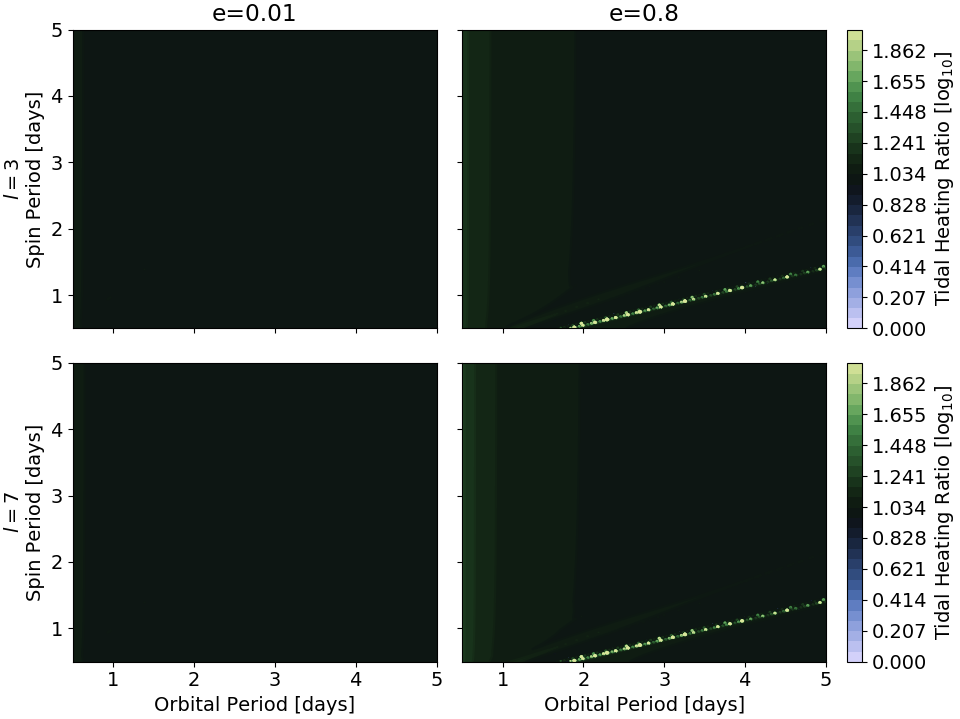

<IPython.core.display.Javascript object>


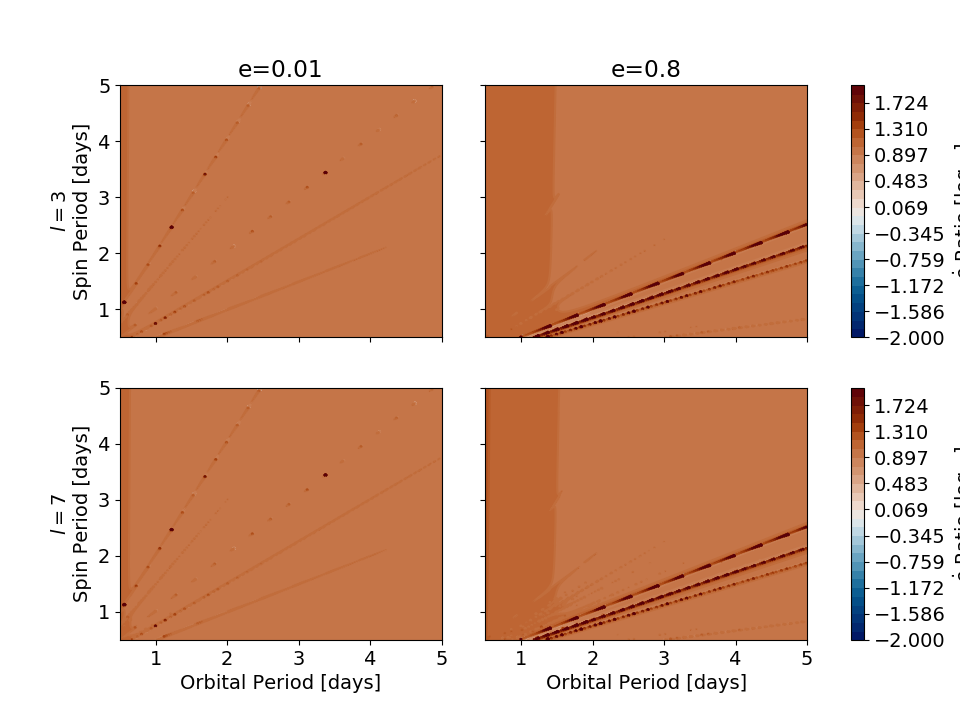

In [38]:
higher_order_l_compare(pluto, charon,
                       obj1_viscosity=5.0e14, obj1_shear=3.3e9, obj1_rheology='Sundberg-Cooper',
                           obj2_viscosity=5.0e14, obj2_shear=3.3e9, obj2_rheology='Sundberg-Cooper',
                           eccentricity_truncation=10,
                           eccentricities=(0.01, 0.8), obj1_obliquity = 0., obj2_obliquity = 0.,
                       save_fig=False)